In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from readers import OpenEphysReader, BinaryReader, ExcelReader
import scipy.io as sio

In [40]:
'''
Traces comparison:
First, we would like to compare the raw data traces.
we will compare 3 "random" segments of 20 seconds from the 22 hrs recording - start (0), 10 hrs later, and 20 hrs later.
1. generating the data by python,
2. uploading the data from the MATLAB, in mat_out_path
3. comparing visually the two signals.

Diff histogram:
for each segment, we want to check the differences in the mV
py_data-MAT_data.
Not an histogram, because they are all 0, so I Showed it in regular plot.

''';

In [ ]:
# loading the record using python readers system by Reggev:

rec_table_folder = '/media/sil1/Nitzan/Experiments/brainStatesWake.xlsx'

rec_table = pd.read_excel(rec_table_folder)
xls = ExcelReader(rec_table) # setting the Excel for all the recordings
rec = xls.get('PV87','Day2') # set the current rec the same as the MATLAB one.

In [5]:
#general data:
# rec full time:
full_time_s = rec.time_vector[-1] - rec.time_vector[0]
full_time_h = full_time_s / (60*60)
full_time_s

80418.09915000001

In [6]:
# loading the Metadata from Matlab
mat_out_path = '/media/E/Nitzan/Pipline_testing/Test_Data/'

#Metadata:
metadata_mat = sio.loadmat(mat_out_path + 'metadata.mat')
MAT_dur_s = metadata_mat.get('rec_dur_s')
t_starts_ms = metadata_mat.get('t_start_ms')

In [8]:
# reading the data using python:
seg_dur_s = 20 #20 seconds of rec for each segment
t_starts_s = t_starts_ms/1000
py_data = {}  # python Data
# builds a dict for the 3 segments, each val is a tuple of the [0]:volts and the [1] times of the segment
for i in range(0,3):
    py_data[str(i+1)] = rec.read(t_start=t_starts_s[0,i], t_stop= t_starts_s[0,i]+ seg_dur_s)


In [12]:
# loading 3 Data segments, from MATLAB output
fs = 20000 # sampling freq
seg_len = 20*fs # 20 sec * the sampling freq
MAT_data = {} # MATLAB data
for i in range(1,4):
    MAT_data[str(i)] = sio.loadmat(mat_out_path + f'seg_{i}.mat')['seg_plot']


In [41]:
# creating a diff vector for each segment
diffs = {}
for i in range(1,4):
    diffs[str(i)] = py_data[str(i)][0] - MAT_data[str(i)].flatten()

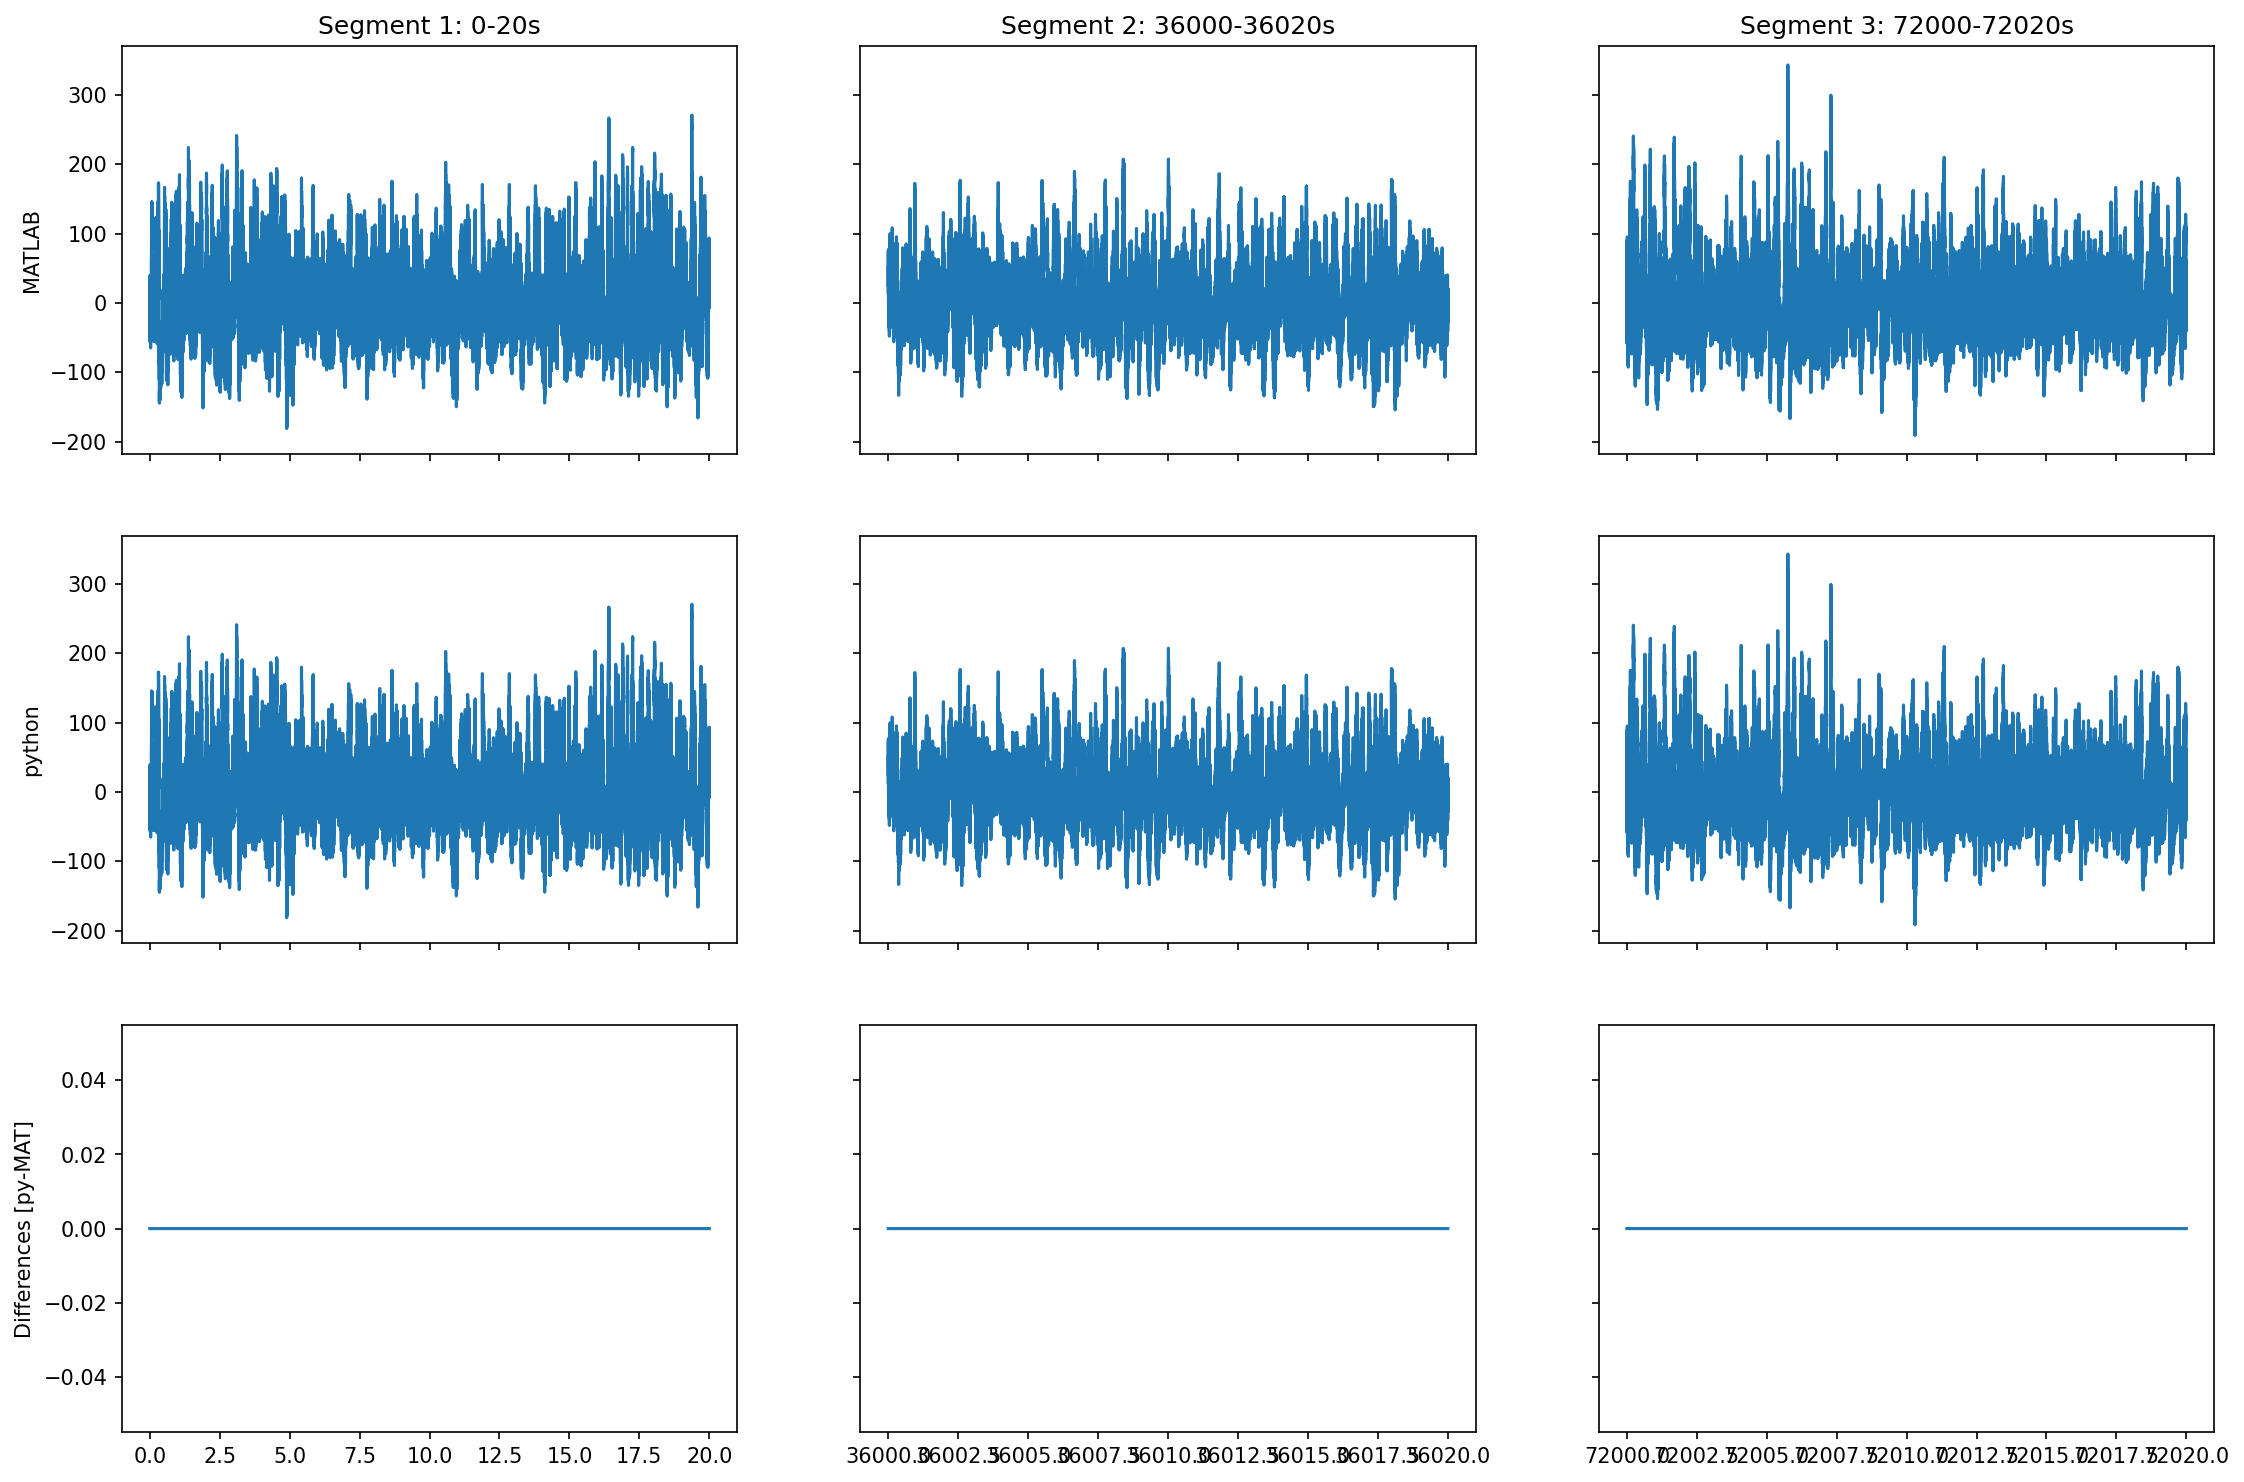

In [38]:
# Plotting the 3 segments. MAT on the top and python on the bottom. segs from left to right.
# also plotting the diffs.

fig, axs = plt.subplots(nrows = 3, ncols = 3,
             sharex = 'col', sharey='row',
                        figsize = (6*3,6*2), dpi = 150)
axes = axs.flatten()

for i, ax in zip(range(1,10),axes):
    if i <4:
        ax.plot(py_data[str(i)][1],MAT_data[str(i)])
    elif i<7:
        ax.plot(py_data[str(i-3)][1],py_data[str(i-3)][0])
    else:
        ax.plot(py_data[str(i-6)][1],diffs[str(i-6)])

axes[0].set_title('Segment 1: 0-20s')
axes[1].set_title('Segment 2: 36000-36020s')
axes[2].set_title('Segment 3: 72000-72020s')
axes[0].set_ylabel('MATLAB')
axes[3].set_ylabel('python')
axes[6].set_ylabel('Differences [py-MAT]')

plt.savefig(mat_out_path+'traces_dif.png')


In [ ]:
'''
Trigger comparison:
 here, I want to compare between the triggers timestamps in the 3 segments.
 1. get triggers from MATLAB
 2/ get triggers from python
 3/ create diff vector
 4/ plot for each segment.
'''

In [130]:
# 1. get triggers from Matlab:
trig_mat = sio.loadmat(mat_out_path + 'triggers.mat')
MAT_triggers = trig_mat.get('triggers') # ON triggers from the MATLAB. not in timestamps, but from time from start timestamp of the rc in ms.

In [129]:
MAT_triggers

array([[1.09101500e+04, 1.09271500e+04, 1.09441000e+04, ...,
        8.04114890e+07, 8.04115060e+07, 8.04135146e+07]])

In [123]:
#2/ get triggers - python:
trig = rec.reader.get_event_timestamps(event_channel_index=0) # getting the timestamps[0], durations (empty), and the labels (#trigerchannel#proccesorID#type)
diffs = np.diff(trig[0])
edges = np.where(diffs>1000)[0]
all_triggers = trig[0]
triggers = all_triggers[edges[0]+1:edges[1]+1] # the variable with timestamps of the video from reptilearn.
# make a vector of only ON triggers in ms from the start


In [132]:
rec.reader.start_timestamp

AttributeError: 'OpenEphysRawIO' object has no attribute 'load_start_timestamp'